# Load Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, mean_squared_error, explained_variance_score

from srcs.utils import load_data, print_scores, get_scores, calculate_metrics
import time
import tracemalloc
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# ignore warnings
import warnings

warnings.filterwarnings('ignore')

# Load Data

In [2]:
df = load_data()

# shuffle the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,0.0,0.43,D,7.0,18.0,36.0,95.0,B1,Regular,1054.0,R24,0.0
1,0.0,0.10,D,7.0,17.0,80.0,95.0,B2,Regular,598.0,R25,0.0
2,0.0,0.33,E,7.0,3.0,36.0,76.0,B6,Regular,4172.0,R82,0.0
3,0.0,0.56,A,5.0,4.0,73.0,52.0,B13,Diesel,15.0,R24,0.0
4,0.0,0.27,E,8.0,0.0,37.0,50.0,B11,Diesel,3021.0,R53,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,0.0,0.35,D,10.0,6.0,57.0,85.0,B12,Diesel,879.0,R82,0.0
678009,0.0,0.87,D,10.0,10.0,46.0,56.0,B5,Diesel,1609.0,R11,0.0
678010,0.0,1.00,E,8.0,8.0,35.0,50.0,B5,Regular,3744.0,R93,0.0
678011,0.0,0.50,E,11.0,1.0,32.0,54.0,B12,Regular,6485.0,R11,0.0


# Feature Engineering

In [3]:
# your feature engineering and data preprocessing here
# e.g.

# drop Area AS it can be inferred from Region
# drop ClaimAmount as we can not use it to predict the number of claims
df.drop(columns=["Area", "ClaimAmount"], inplace=True)

# drop as kaggler's notebook
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)

df["VehAge"] = df["VehAge"].clip(upper=np.percentile(df["VehAge"], 97.5))
df["DrivAge"] = df["DrivAge"].clip(upper=np.percentile(df["DrivAge"], 97.5))

df = pd.get_dummies(df, columns=["VehBrand", "VehPower", "VehGas", "Region"], drop_first=True)

df["Density"] = np.log(df["Density"])
df["VehAge2"] = df["VehAge"] ** 2
df["DrivAge2"] = df["DrivAge"] ** 2

df["VehAge3"] = df["VehAge"] ** 3
df["DrivAge3"] = df["DrivAge"] ** 3

df["VehAge4"] = df["VehAge"] ** 4
df["DrivAge4"] = df["DrivAge"] ** 4

df["VehAge5"] = df["VehAge"] ** 5
df["DrivAge5"] = df["DrivAge"] ** 5

df["VehAge6"] = df["VehAge"] ** 6
df["DrivAge6"] = df["DrivAge"] ** 6


In [4]:
df

,ClaimNb,Exposure,VehAge,DrivAge,BonusMalus,Density,VehBrand_B10,VehBrand_B11,VehBrand_B12,VehBrand_B13,...,VehAge2,DrivAge2,VehAge3,DrivAge3,VehAge4,DrivAge4,VehAge5,DrivAge5,VehAge6,DrivAge6
0,0.0,0.43,18.0,36.0,95.0,6.960348,0,0,0,0,...,324.0,1296.0,5832.0,46656.0,104976.0,1679616.0,1889568.0,6.046618e+07,34012224.0,2.176782e+09
1,0.0,0.10,17.0,76.0,95.0,6.393591,0,0,0,0,...,289.0,5776.0,4913.0,438976.0,83521.0,33362176.0,1419857.0,2.535525e+09,24137569.0,1.926999e+11
2,0.0,0.33,3.0,36.0,76.0,8.336151,0,0,0,0,...,9.0,1296.0,27.0,46656.0,81.0,1679616.0,243.0,6.046618e+07,729.0,2.176782e+09
3,0.0,0.56,4.0,73.0,52.0,2.708050,0,0,0,1,...,16.0,5329.0,64.0,389017.0,256.0,28398241.0,1024.0,2.073072e+09,4096.0,1.513342e+11
4,0.0,0.27,0.0,37.0,50.0,8.013343,0,1,0,0,...,0.0,1369.0,0.0,50653.0,0.0,1874161.0,0.0,6.934396e+07,0.0,2.565726e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678008,0.0,0.35,6.0,57.0,85.0,6.778785,0,0,1,0,...,36.0,3249.0,216.0,185193.0,1296.0,10556001.0,7776.0,6.016921e+08,46656.0,3.429645e+10
678009,0.0,0.87,10.0,46.0,56.0,7.383368,0,0,0,0,...,100.0,2116.0,1000.0,97336.0,10000.0,4477456.0,100000.0,2.059630e+08,1000000.0,9.474297e+09
678010,0.0,1.00,8.0,35.0,50.0,8.227910,0,0,0,0,...,64.0,1225.0,512.0,42875.0,4096.0,1500625.0,32768.0,5.252188e+07,262144.0,1.838266e+09
678011,0.0,0.50,1.0,32.0,54.0,8.777247,0,0,1,0,...,1.0,1024.0,1.0,32768.0,1.0,1048576.0,1.0,3.355443e+07,1.0,1.073742e+09


In [5]:
# do not change the fellowing code
X = df.drop(columns=['ClaimNb'])
y = df['ClaimNb']

# data integrity check
# make sure we do not drop some rows
assert X.shape[0] == load_data().shape[0]
# assert ClaimAmount is not in X, as ClaimAmount can not be used to predict the number of claims
assert "ClaimAmount" not in X.columns
# assert Frequency is not in X, as Frequency can not be used to predict the number of claims
assert "Frequency" not in X.columns

# Model Evaluation


In [6]:
# use to store the scores of each model
results = []

## Naive Poisson Regression

In [7]:
scores = get_scores(model_name="Naive Poisson Regression")
"""
Please specify the model here
"""
from sklearn.linear_model import PoissonRegressor

naive_poisson = PoissonRegressor()

kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in tqdm(kf5.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    """Train the model"""
    tracemalloc.start()
    start = time.time()

    # enter your model training here
    model = naive_poisson.fit(X_train, y_train, sample_weight=X_train["Exposure"])

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["train_time"].append(end - start)
    scores["train_memory"].append(peak)

    """Test the model"""
    start = time.time()
    tracemalloc.start()

    # enter your model testing here
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["test_time"].append(end - start)
    scores["test_memory"].append(peak)

    """Calculate the Metrics"""
    scores = calculate_metrics(scores, y_train, y_pred_train, y_test, y_pred_test)
results.append(scores)
print_scores(scores)

0it [00:00, ?it/s]

model: Naive Poisson Regression
train_MAE:0.0568;(std:0.0002)
test_MAE:0.0568;(std:0.0007)
train_Max_Error:3.9354;(std:0.0002)
test_Max_Error:3.7354;(std:0.4002)
train_Mean_Poisson_Deviance:0.3226;(std:0.0006)
test_Mean_Poisson_Deviance:0.3226;(std:0.0022)
train_explained_variance:0.0000;(std:0.0000)
test_explained_variance:0.0000;(std:0.0000)
train_time:0.1606;(std:0.0127)
test_time:0.0712;(std:0.0046)
train_memory:269085917.2000;(std:28598.0880)
test_memory:256019399.2000;(std:1315.6204)


## XGBoost Poisson Regression

In [8]:
scores = get_scores(model_name="XGBoost Poisson Regression")
"""
Please specify the model here
"""
from xgboost import XGBRegressor

xgboost_poisson_model = XGBRegressor(objective="count:poisson")

kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in tqdm(kf5.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    """Train the model"""
    tracemalloc.start()
    start = time.time()

    # enter your model training here
    model = xgboost_poisson_model.fit(X_train, y_train, sample_weight=X_train["Exposure"])

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["train_time"].append(end - start)
    scores["train_memory"].append(peak)

    """Test the model"""
    start = time.time()
    tracemalloc.start()

    # enter your model testing here
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["test_time"].append(end - start)
    scores["test_memory"].append(peak)

    """Calculate the Metrics"""
    scores = calculate_metrics(scores, y_train, y_pred_train, y_test, y_pred_test)

results.append(scores)
print_scores(scores)

0it [00:00, ?it/s]

model: XGBoost Poisson Regression
train_MAE:0.0530;(std:0.0002)
test_MAE:0.0542;(std:0.0006)
train_Max_Error:3.9836;(std:0.0018)
test_Max_Error:3.7777;(std:0.3965)
train_Mean_Poisson_Deviance:0.2799;(std:0.0005)
test_Mean_Poisson_Deviance:0.2900;(std:0.0017)
train_explained_variance:0.0644;(std:0.0009)
test_explained_variance:0.0422;(std:0.0023)
train_time:1.6380;(std:0.0511)
test_time:0.1982;(std:0.0077)
train_memory:256059612.2000;(std:29618.4685)
test_memory:253860468.8000;(std:16207.1776)


In [16]:
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.9 MB/s eta 0:00:00a 0:00:010m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for lightgbm (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [38 lines of output]
      2024-02-12 11:36:50,030 - scikit_build_core - INFO - CMake version: 3.28.3
      *** scikit-build-core 0.8.0 using CMake 3.28.3 (wheel)
      2024-02-12 11:36:50,033 - scikit_build_core - INFO - Build directory: /private/var/folders/hr/75zrrvy97tx55lfdt1gjjz5r0000gn/T/tmp48ilz1tm/build
      *** Configuring CMake...
      2024-02-12 11:36:50,363 - scikit_build_core - INFO - Ninja version: 1.11.1
      2024-02-12 11:36:50,364 - scikit_build_core - WARNING - libdir/ldlibrary: /opt/anaconda3/lib/libpython3.9.a is not a real file!
      2024-02-12 11:36:50,364 - sc

In [13]:
pip install --upgrade pip setuptools wheel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 5.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.37.1
    Uninstalling wheel-0.37.1:
      Successfully uninstalled wheel-0.37.1
  Attempting uninstall: setuptools
    Found existing installation: setuptools 63.4.1
    Uninstalling setuptools-63.4.1:
      Successfully uninstalled setuptools-63.4.1
  Attempting uninstall: pip
    Found existing installation: pip 22.2.2
    Uninstalling pip-22.2.2:
      Successfully uninstalled pip-22.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.20 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-

In [15]:
conda install -c conda-forge lightgbm

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/osx-arm64::anaconda==2022.10=py39_0
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: - ^C
failed with repodata from current_repodata.json, will retry with next repodata source.

CondaError: KeyboardInterrupt


Note: you may need to restart the kernel to use updated packages.


## LightGBM Poisson Regression

In [10]:
scores = get_scores(model_name="LightGBM Poisson Regression")
"""
Please specify the model here
"""
from lightgbm import LGBMRegressor

lightgbm_poisson_model = LGBMRegressor(objective="poisson")

kf5 = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in tqdm(kf5.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    """Train the model"""
    tracemalloc.start()
    start = time.time()

    # enter your model training here
    model = lightgbm_poisson_model.fit(X_train, y_train, sample_weight=X_train["Exposure"])

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["train_time"].append(end - start)
    scores["train_memory"].append(peak)

    """Test the model"""
    start = time.time()
    tracemalloc.start()

    # enter your model testing here
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["test_time"].append(end - start)
    scores["test_memory"].append(peak)

    """Calculate the Metrics"""
    scores = calculate_metrics(scores, y_train, y_pred_train, y_test, y_pred_test)

results.append(scores)
print_scores(scores)

0it [00:00, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1016
[LightGBM] [Info] Number of data points in the train set: 542410, number of used features: 58
[LightGBM] [Info] Start training from score -2.742141
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1014
[LightGBM] [Info] Number of data points in the train set: 542410, number of used features: 58
[LightGBM] [Info] Start training from score -2.738841
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 542410, number of used features: 58
[LightGBM] [Info] Star

## CatBoost Poisson Regression -- too slow if you want to run it, please delete the comment

In [11]:
# scores = get_scores(model_name="CatBoost Poisson Regression")
# """
# Please specify the model here
# """
# from catboost import CatBoostRegressor
# 
# catboost_poisson_model = CatBoostRegressor(loss_function="Poisson", verbose=False)
# 
# kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
# 
# for train_index, test_index in tqdm(kf5.split(X)):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
# 
#     """Train the model"""
#     tracemalloc.start()
#     start = time.time()
# 
#     # enter your model training here
#     model = catboost_poisson_model.fit(X_train, y_train, sample_weight=X_train["Exposure"])
# 
#     end = time.time()
#     _, peak = tracemalloc.get_traced_memory()
#     tracemalloc.stop()
#     scores["train_time"].append(end - start)
#     scores["train_memory"].append(peak)
# 
#     """Test the model"""
#     start = time.time()
#     tracemalloc.start()
# 
#     # enter your model testing here
#     y_pred_train = model.predict(X_train)
#     y_pred_test = model.predict(X_test)
# 
#     end = time.time()
#     _, peak = tracemalloc.get_traced_memory()
#     tracemalloc.stop()
#     scores["test_time"].append(end - start)
#     scores["test_memory"].append(peak)
# 
#     """Calculate the Metrics"""
#     scores = calculate_metrics(scores, y_train, y_pred_train, y_test, y_pred_test)
# 
# results.append(scores)
# print_scores(scores)

## Hurdle

In [9]:
scores = get_scores(model_name="Hurdle Model")
"""
Please specify the model here
"""
# TODO: enter your model here,e.g.
# your_model = YourModel()
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm


kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf5.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    """Train the model"""
    tracemalloc.start()
    start = time.time()

    # enter your model training here
    # TODO: enter your model training here,e.g.
    # model = your_model.fit(X_train, y_train)
    y_train_binary = (y_train > 0).astype(int)
    X_train_with_intercept = sm.add_constant(X_train)
    X_test_with_intercept = sm.add_constant(X_test)
    logit_model = sm.Logit(y_train_binary, X_train_with_intercept)
    result = logit_model.fit()
    poisson_model = sm.GLM(y_train[y_train > 0], X_train[y_train > 0], family = sm.families.Poisson(),
                           offset=X_train[y_train > 0]['Exposure']).fit()

    
    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["train_time"].append(end - start)
    scores["train_memory"].append(peak)

    """Test the model"""
    start = time.time()
    tracemalloc.start()

    # enter your model testing here
    # TODO: enter your model testing here
    # make sure the output is y_pred_train and y_pred_test,e.g.
    # y_pred_train = model.predict(X_train)
    # y_pred_test = model.predict(X_test)
    
    y_pred_train_prob = result.predict(X_train_with_intercept)
    y_pred_train_binary = np.where(y_pred_train_prob > 0.5, 1, 0)
    
    X_train_positive = X_train[y_pred_train_binary > 0]
    y_pred_train_counts = poisson_model.predict(X_train_positive)
    y_pred_train = np.zeros(y_train.shape)
    y_pred_train[y_pred_train_binary > 0] = y_pred_train_counts
    
    y_pred_train = y_pred_train + 0.00001
    
    y_pred_test_prob = result.predict(X_test_with_intercept)
    y_pred_test_binary = np.where(y_pred_test_prob > 0.5, 1, 0)
    X_test_positive = X_test[y_pred_test_binary > 0]
    y_pred_test_counts = poisson_model.predict(X_test_positive)
    y_pred_test = np.zeros(y_test.shape)
    y_pred_test[y_pred_test_binary > 0] = y_pred_test_counts
    
    y_pred_test = y_pred_test + 0.00001
    
    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["test_time"].append(end - start)
    scores["test_memory"].append(peak)

    """Calculate the Metrics"""
    scores = calculate_metrics(scores, y_train, y_pred_train, y_test, y_pred_test)

results.append(scores)
print_scores(scores)

Optimization terminated successfully.
         Current function value: 0.190238
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.191090
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.190777
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.191107
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.190331
         Iterations 8
model: Hurdle Model
train_MAE:0.0594;(std:0.0002)
test_MAE:0.0594;(std:0.0008)
train_Max_Error:4.0000;(std:0.0000)
test_Max_Error:3.8000;(std:0.4000)
train_Mean_Poisson_Deviance:1.1260;(std:0.0032)
test_Mean_Poisson_Deviance:1.1260;(std:0.0126)
train_explained_variance:0.0003;(std:0.0001)
test_explained_variance:0.0003;(std:0.0003)
train_time:5.1571;(std:0.8197)
test_time:0.0642;(std:0.0041)
train_memory:920446852.2000;(std:22203.2505)
test_memory:269036670.4000;(std:413.3578)


# Summary

In [10]:
df_results = pd.DataFrame()
for result in results:
    df_results = pd.concat([df_results, pd.DataFrame(result)])

df_results.groupby("model").mean().sort_values(by="test_MAE")

,train_MAE,test_MAE,train_Max_Error,test_Max_Error,train_Mean_Poisson_Deviance,test_Mean_Poisson_Deviance,train_explained_variance,test_explained_variance,train_time,test_time,train_memory,test_memory
model,,,,,,,,,,,,
XGBoost Poisson Regression,0.052974,0.054233,3.983610,3.777674,0.279905,0.289959,0.064423,4.218952e-02,1.638039,0.198182,256059612.2,253860468.8
Naive Poisson Regression,0.056753,0.056753,3.935389,3.735389,0.322571,0.322576,0.000000,2.220446e-17,0.160596,0.071198,269085917.2,256019399.2
Hurdle Model,0.059432,0.059432,3.999990,3.799990,1.125996,1.125996,0.000265,2.636423e-04,5.157051,0.064214,920446852.2,269036670.4


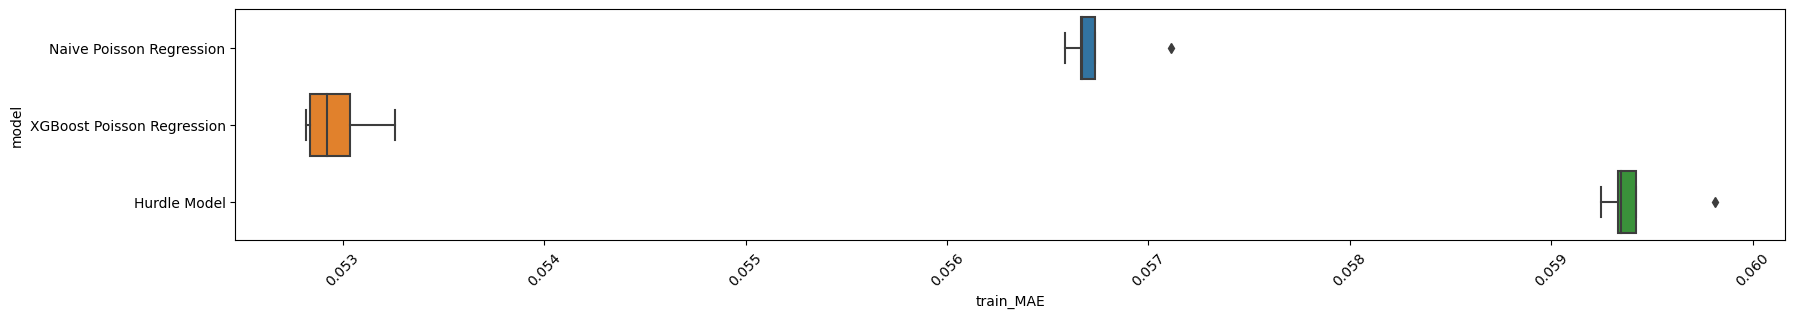

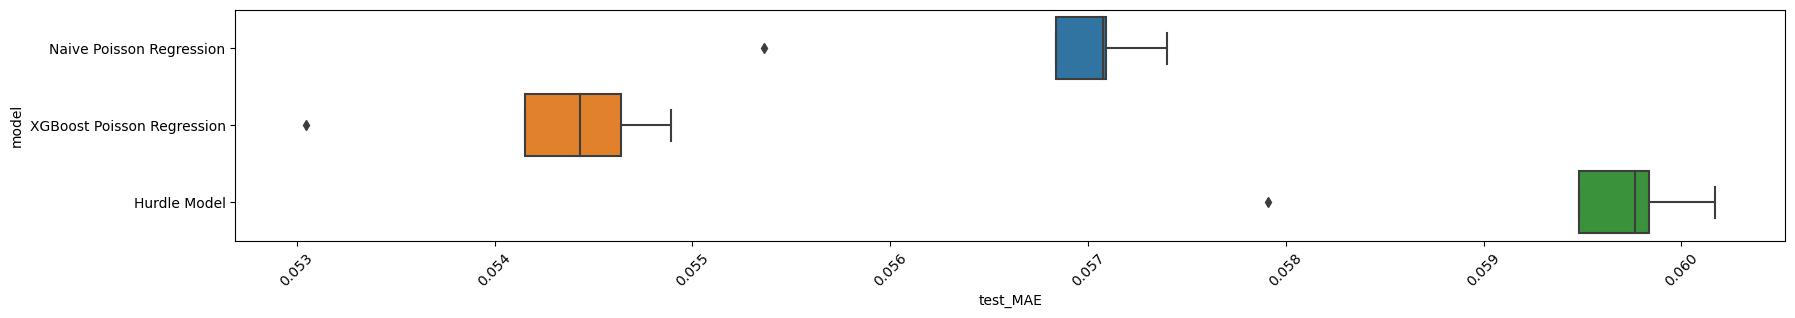

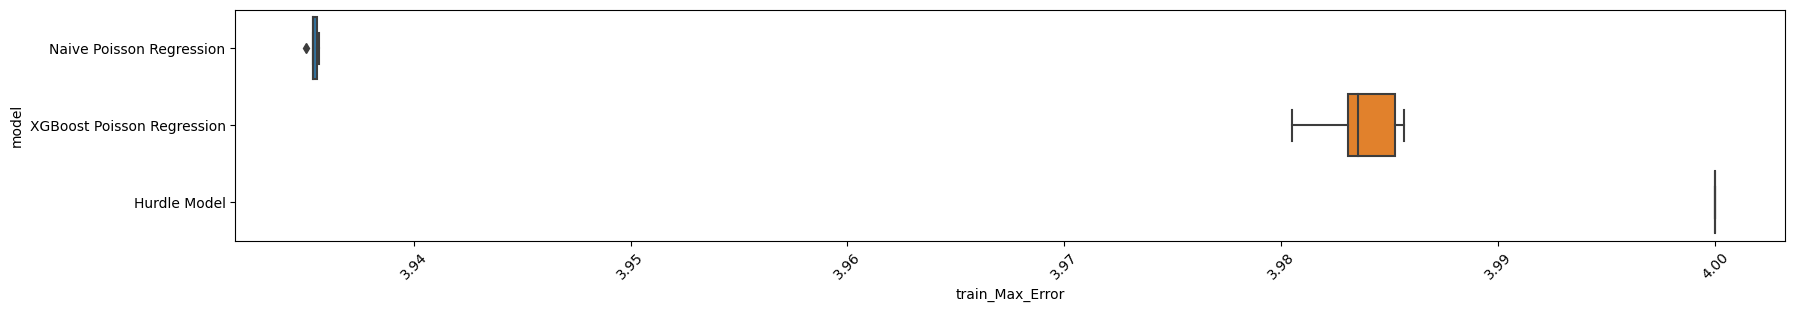

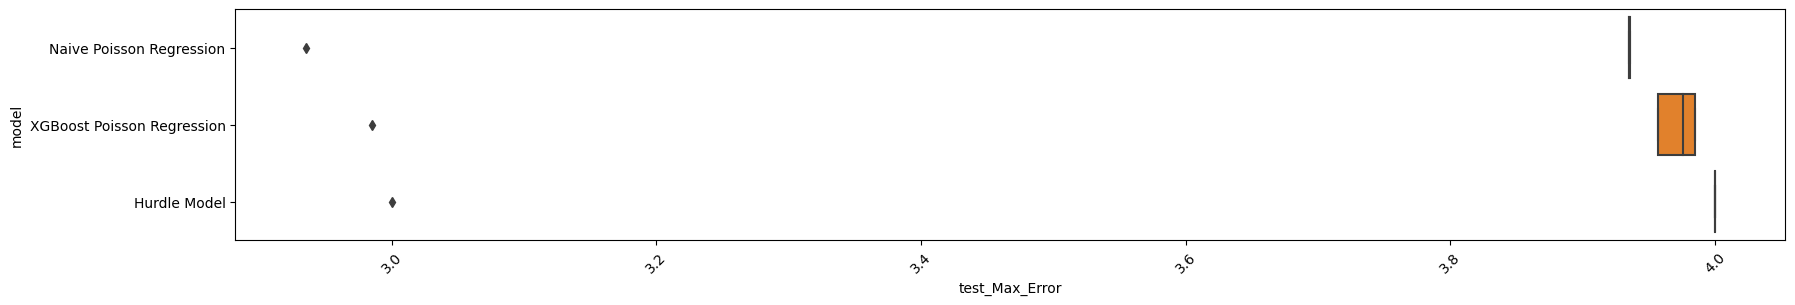

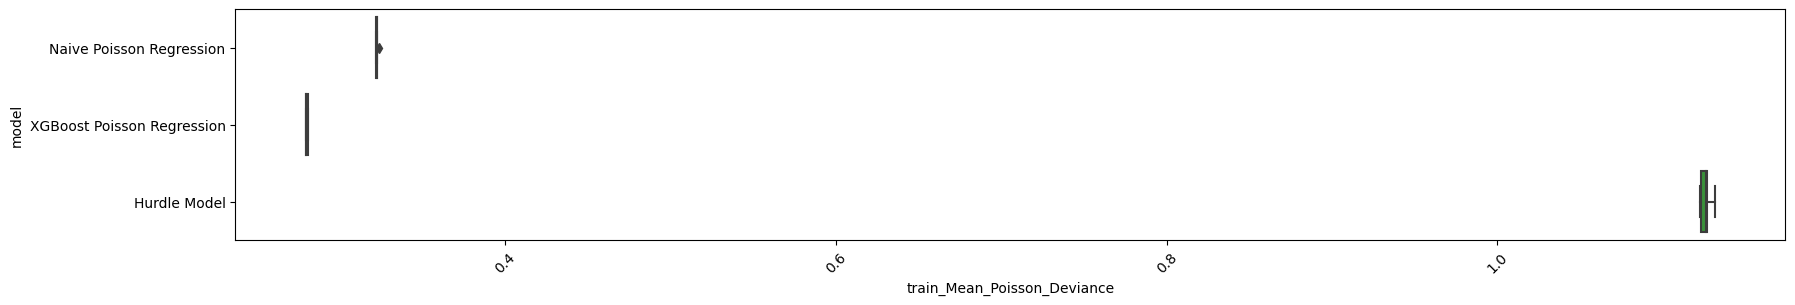

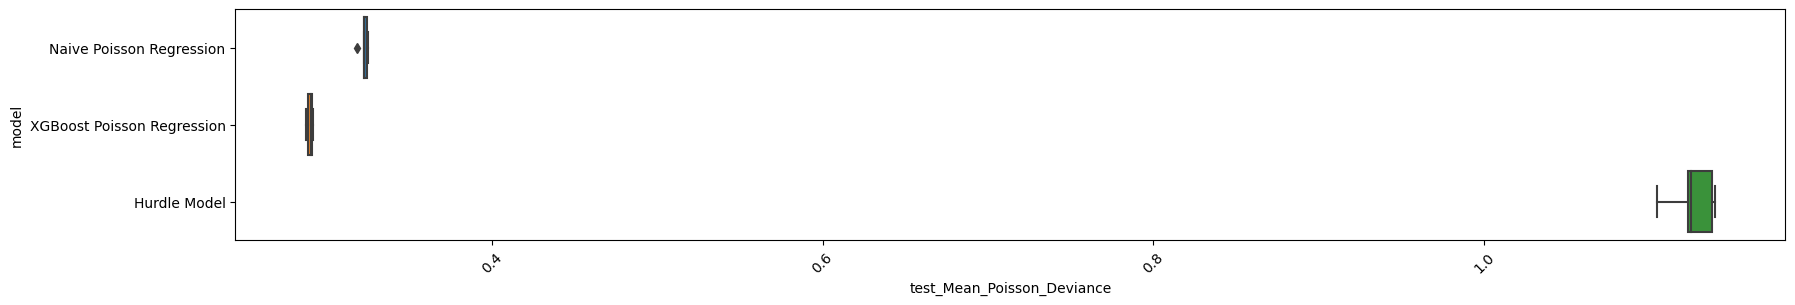

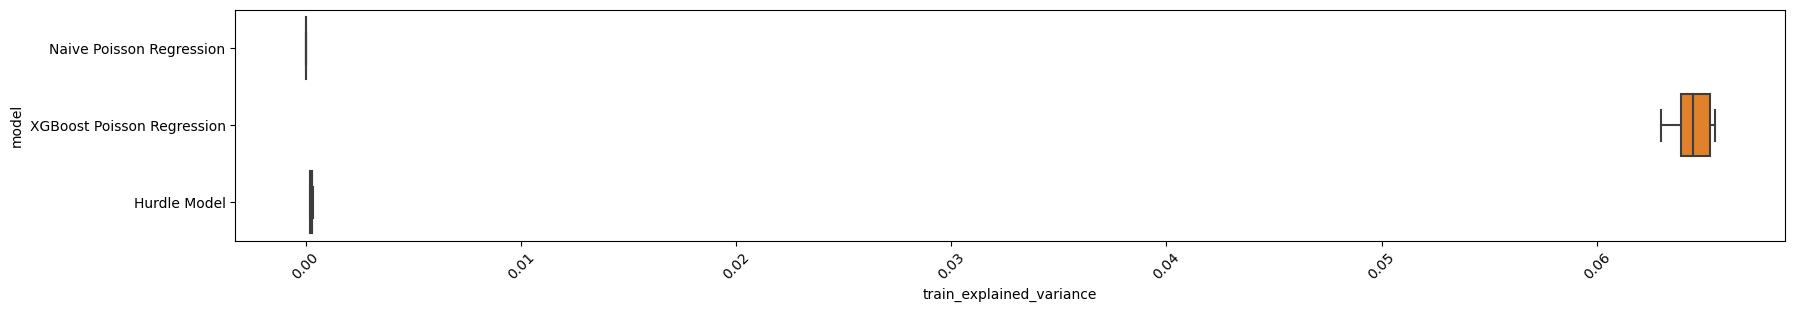

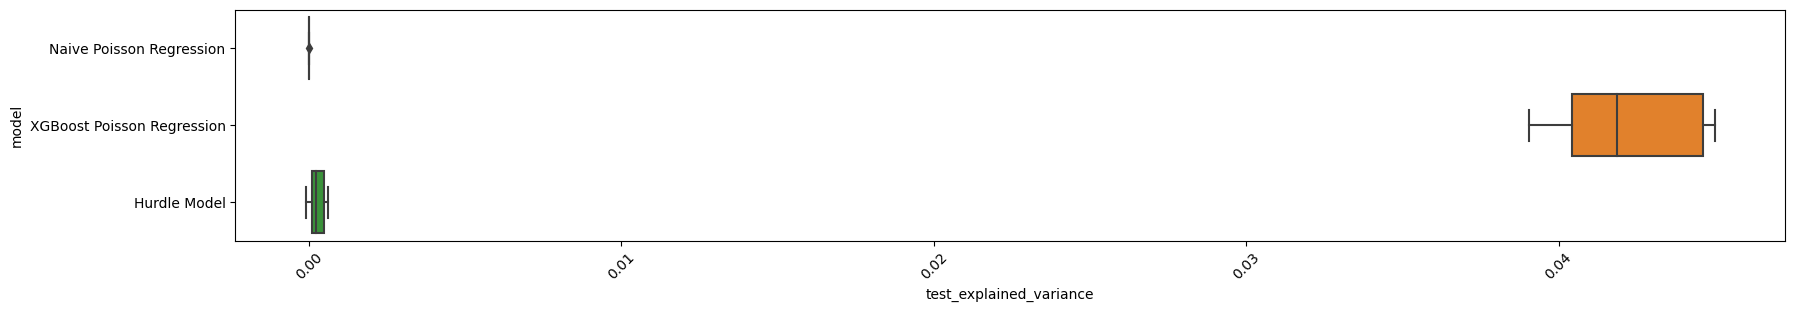

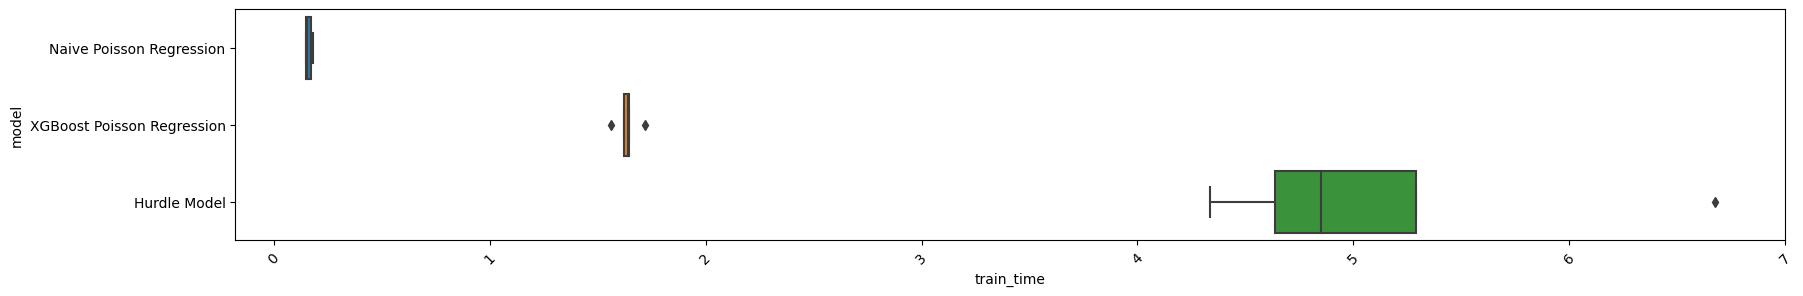

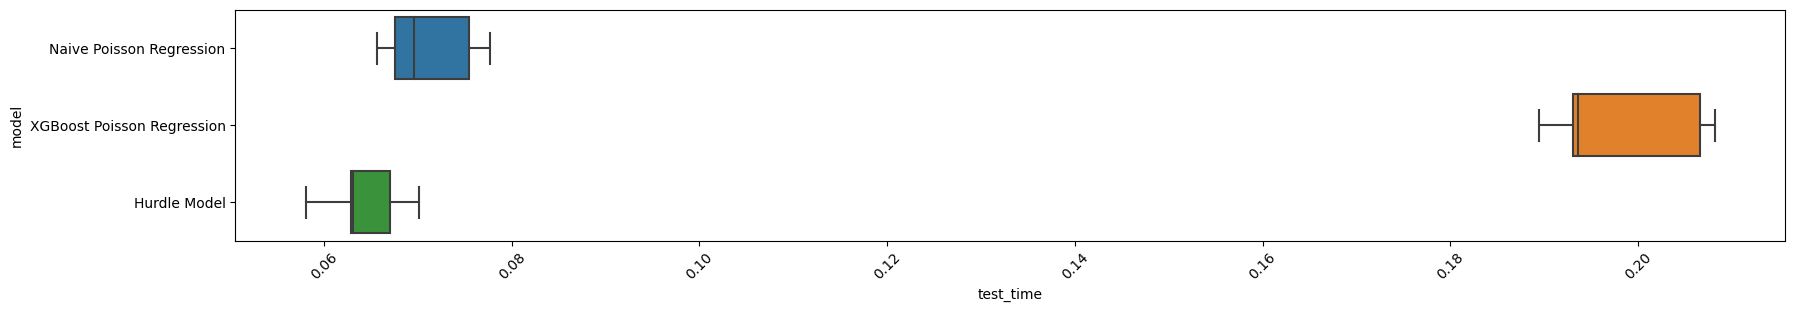

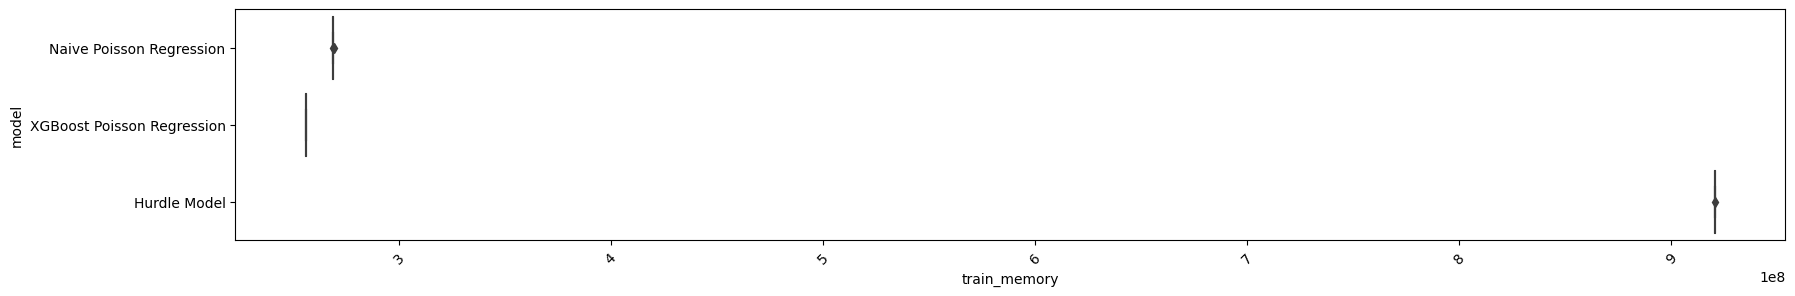

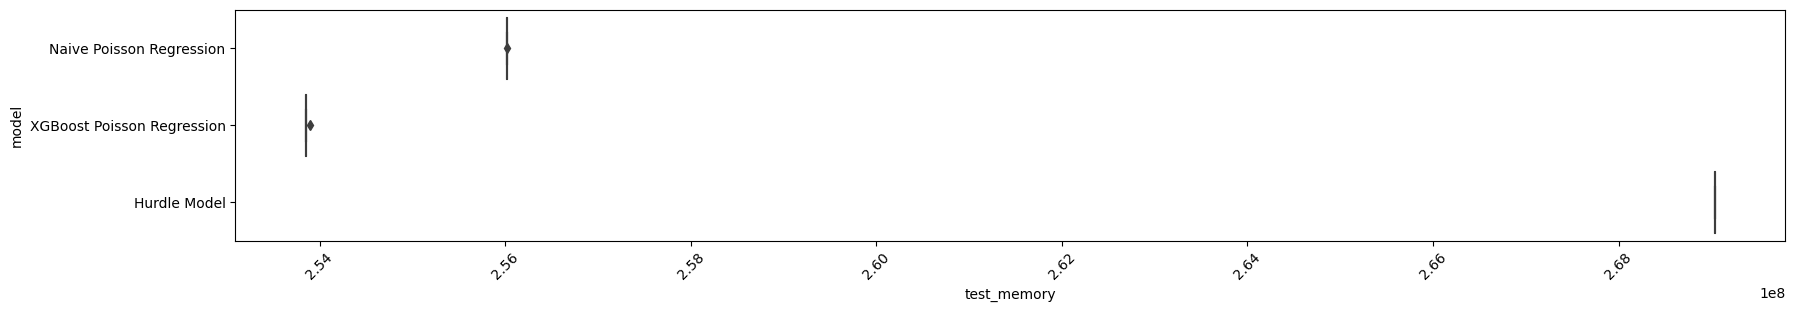

In [11]:
for metric in results[0].keys():
    if metric != "model":
        plt.figure(figsize=(20, len(results)))
        sns.boxplot(data=df_results, y="model", x=metric)
        plt.xticks(rotation=45)
        plt.show()